# GeoConnex

In [16]:
from pathlib import Path

from pynhd import GeoConnex

[GeoConnex](https://geoconnex.internetofwater.dev/) is a web service developed by [Internet Of Water](https://internetofwater.org/) that provides access to many hydro-linked datasets. PyNHD provides access to all GeoConnex endpoints.

To explore available datasets in GeoConnex (endpoints), we start by instantiating a `pynhd.GeoConnex` class.

In [17]:
gcx = GeoConnex(dev=False)
print("\n".join(f"{n}: {e.description}" for n, e in gcx.endpoints.items()))

hu02: Two-digit Hydrologic Regions from USGS NHDPlus High Resolution
hu04: Four-digit Hydrologic Subregion from USGS NHDPlus High Resolution
hu06: Six-digit Hydrologic Basins from USGS NHDPlus High Resolution
hu08: Eight-digit Hydrologic Subbasins from USGS NHDPlus High Resolution
hu10: Ten-digit Watersheds from USGS NHDPlus High Resolution
nat_aq: National Aquifers of the United States from USGS National Water Information System National Aquifer code list
principal_aq: Principal Aquifers of the United States from 2003 USGS data release
sec_hydrg_reg: Secondary Hydrogeologic Regions of the Conterminous United States from 2018 USGS data release
gages: United States community contributed reference Stream Gage Monitoring Locations
mainstems: United States community ontributed reference Mainstem Rivers
dams: United States Community Contributed Reference Dams
pws: Public Water Systems from United States EPA Safe Drinking Water Information System
states: States from United States Census Bure

`pynhd.GeoConnex` provides three ways of querying GeoConnex: Spatial query, by ID, and using CQL filters.
CQL filter is powerful and can be used for all sort of queries, however, using them require some knowledge of CQL filter which you can learn from [here](https://portal.ogc.org/files/96288#simple-cql-JSON). For example, let's say that we want to find all urban clusters in the US that have water area of larger than 100 km$^2$. We can use the following CQL filter to do so:

In [18]:
gcx.item = "ua10"
awa = gcx.bycql({"gt": [{"property": "awater10"}, 100e6]})
awa.name10

0                Boston, MA--NH--RI
1                    Cape Coral, FL
2                   Chicago, IL--IN
3                  Jacksonville, FL
4                         Miami, FL
5     Minneapolis--St. Paul, MN--WI
6      New York--Newark, NY--NJ--CT
7                       Orlando, FL
8           Palm Bay--Melbourne, FL
9      Philadelphia, PA--NJ--DE--MD
10          Sarasota--Bradenton, FL
11                      Seattle, WA
12        Tampa--St. Petersburg, FL
13               Virginia Beach, VA
Name: name10, dtype: object

For demonstrating spatial query and query by ID, let's say that we are interested in getting all mainstems within HUC 02 (Mid Atlantic Region). We can start by getting HUC 02's geometry and then carry out a spatial query to get all mainstems within HUC 02. For this purpose, first we select `huc02` endpoint (or item) from GeoConnex and then use `query` to get the geometry of HUC 02. We can the queryable fields of this item by just printing the instance of `GeoConnext` class that we just created.

In [62]:
gcx.item = "hu02"
gcx

Item: 'hu02'
Description: Two-digit Hydrologic Regions from USGS NHDPlus High Resolution
Queryable Fields: fid, uri, name, gnis_url, gnis_id, huc2, loaddate
Extent: (-170, 15, -51, 72)

Therefore, we should query `huc2` field and pass `02` as the value.

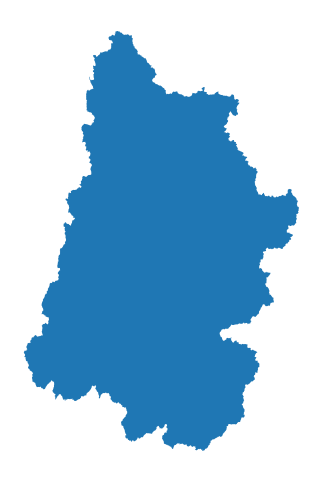

In [63]:
h2 = gcx.byid("huc2", "14")
ax = h2.plot(figsize=(6, 6))
ax.set_axis_off()

With this geometry, we can query the mainstems that are `within` HUC 02:

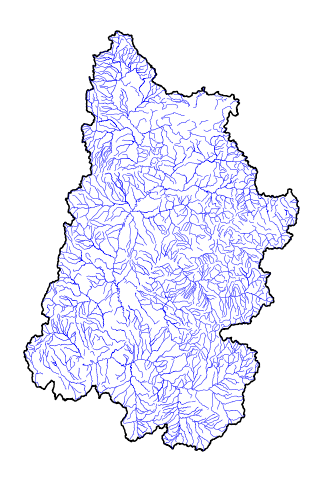

In [64]:
gcx.item = "mainstems"
ms = gcx.bygeometry(h2.geometry.iloc[0], predicate="within", crs=h2.crs)
ax = h2.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
ms.plot(ax=ax, color="b", lw=0.3)
ax.set_axis_off()

Next, let's say that we need all dams that are located on the headwater flowline of the mainstems that we just obtained. We set the endpoint to `dams` and find its queryable field of that's related to NHDPlusc2 ComIDs.

In [65]:
gcx.item = "dams"
gcx

Item: 'dams'
Description: United States Community Contributed Reference Dams
Queryable Fields: fid, id, uri, name, description, subjectof, provider, provider_id, nhdpv2_comid, nhdpv2_reachcode_uri, nhdpv2_reachcode, nhdpv2_reach_measure, drainage_area_sqkm, drainage_area_sqkm_nhdpv2, index_type, mainstem_uri, feature_data_source
Extent: (-170, 15, -51, 72)

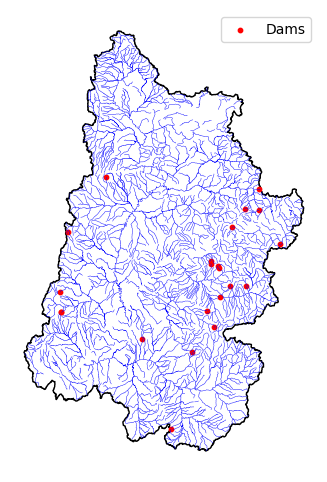

In [66]:
dam = gcx.byid("nhdpv2_comid", ms.head_nhdpv2_comid)
ax = h2.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
ms.plot(ax=ax, color="b", lw=0.3)
dam.plot(ax=ax, color="r", markersize=10, label="Dams")
ax.legend()
ax.set_axis_off()

Let's find gage stations that located outlets of the mainstems. We use `gages` endpoint and find its queryable field that's related to NHDPlusc2 ComIDs.

In [67]:
gcx.item = "gages"
gcx

Item: 'gages'
Description: United States community contributed reference Stream Gage Monitoring Locations
Queryable Fields: fid, id, uri, name, description, subjectof, provider, provider_id, nhdpv2_reachcode, nhdpv2_reach_measure, nhdpv2_comid, mainstem_uri, cluster
Extent: (-170, 15, -51, 72)

We can check out the data type of the `nhdpv2_comid` in this dataset using the `endpoints` property of the `GeoConnex` class.

In [68]:
gcx.endpoints["gages"].dtypes

{'fid': 'int64',
 'id': 'int64',
 'uri': 'str',
 'name': 'str',
 'description': 'str',
 'subjectof': 'str',
 'provider': 'str',
 'provider_id': 'str',
 'nhdpv2_reachcode': 'str',
 'nhdpv2_reach_measure': 'f8',
 'nhdpv2_comid': 'f8',
 'mainstem_uri': 'str',
 'cluster': 'str'}

We notice that `nhdpv2_comid` is a float and since in the mainstem dataset `outlet_nhdpv2_comid` is a URL, we need to extract the ComIDs values. First, we should find the outlet ComIDs of the mainstems that these dams are located on.

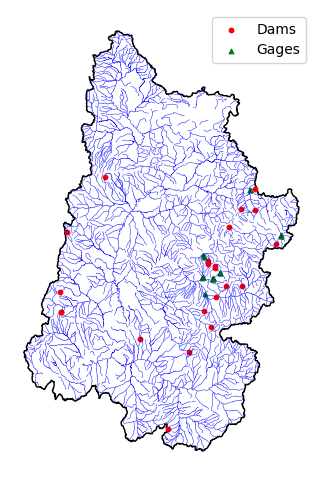

In [69]:
outlet_ids = ms.loc[ms["head_nhdpv2_comid"].isin(dam["nhdpv2_comid"]), "outlet_nhdpv2_comid"]
comids = outlet_ids.str.rsplit("/", n=1).str[-1].astype(float)
gages = gcx.byid("nhdpv2_comid", comids)
ax = h2.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
ms.plot(ax=ax, color="b", lw=0.3)
dam.plot(ax=ax, color="r", markersize=10, label="Dams")
gages.plot(ax=ax, color="g", markersize=10, marker="^", label="Gages")
ax.legend()
ax.set_axis_off()

We notice that some dams don't have any downstream gages, so we need to filter those out:

In [70]:
gage_comid = "https://geoconnex.us/nhdplusv2/comid/" + gages.nhdpv2_comid.astype("Int64").astype(
    str
)
cond = ms["head_nhdpv2_comid"].isin(dam["nhdpv2_comid"]) & ms["outlet_nhdpv2_comid"].isin(
    gage_comid
)
pair_ids = ms.loc[cond, ["head_nhdpv2_comid", "outlet_nhdpv2_comid"]]
dam_ids = dam[dam["nhdpv2_comid"].isin(pair_ids["head_nhdpv2_comid"])]
pair_ids["outlet_nhdpv2_comid"] = (
    pair_ids["outlet_nhdpv2_comid"].str.rsplit("/", n=1).str[-1].astype(float)
)
gage_ids = gages[gages["nhdpv2_comid"].isin(pair_ids["outlet_nhdpv2_comid"])]

We need to add a common column for dams and gages, so we can pair them later on, if needed.

In [72]:
gage_ids = gage_ids.set_index("nhdpv2_comid")
gage_ids["head_nhdpv2_comid"] = pair_ids.set_index("outlet_nhdpv2_comid")["head_nhdpv2_comid"]
gage_ids = gage_ids.reset_index()

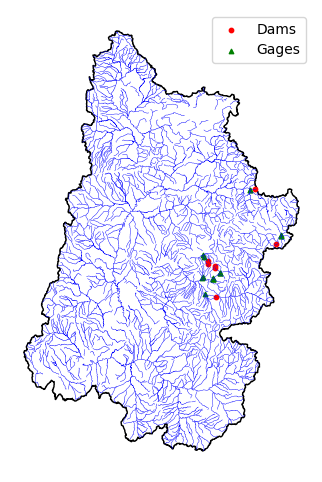

In [73]:
ax = h2.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
ms.plot(ax=ax, color="b", lw=0.3)
dam_ids.plot(ax=ax, color="r", markersize=10, label="Dams")
gage_ids.plot(ax=ax, color="g", markersize=10, marker="^", label="Gages")
ax.legend()
ax.set_axis_off()
ax.figure.savefig(Path("_static/geoconnex.png"), dpi=100, bbox_inches="tight")